# "True Range" limits
This code uses estimated fish range limits and checks them against existing Aquamaps' contemporary range estimates.
Once ECDFs running south-north of each fish density map are generated, they are checked against those estimates, using the percentile of the Aquamaps distribution at which the latutude estimate falls as the main indicator of performance.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# True Range Limit Cleaning

In [14]:
# true leading and trailing edge datasets
trail = pd.read_excel('true_lims/true_trailing_edge_data_for_christian.xlsx')
lead = pd.read_excel('true_lims/true_leading_edge_data_for_christian.xlsx')

trail['estimated_2019'] = trail.intercept + 2019 * trail.slope
lead['estimated_2019'] = lead.intercept + 2019 * lead.slope

trail = trail.loc[trail.end_year >= 2014].reset_index(drop = True)
lead = lead.loc[lead.end_year >= 2014].reset_index(drop = True)

# obtain all fish scientific names for species we have Aquamaps data for
fishnames = pd.read_csv('species_lists/fish_fullnames.csv')
missing = pd.read_csv('species_lists/missing_species.csv')

missing['sci_name'] = [f"{missing.genus[i]} {missing.species[i]}" for i in range(len(missing))]
fishnames['sci_name'] = [f"{fishnames.genus[i]} {fishnames.species[i]}" for i in range(len(fishnames))]
f = fishnames.loc[~fishnames.sci_name.isin(missing.sci_name)].reset_index(drop = True)

# restrict dataframes trail and head to only include fish listed in f
trail = trail.loc[trail.accepted_name.isin(f.sci_name)].reset_index(drop = True)
lead = lead.loc[lead.accepted_name.isin(f.sci_name)].reset_index(drop = True)

trail['most_recent'] = trail.intercept + trail.end_year * trail.slope
lead['most_recent'] = lead.intercept + lead.end_year * lead.slope

In [4]:
trail.ocean_continent.unique()

array(['Atlantic Ocean-North America', 'Atlantic Ocean-Europe',
       'Pacific Ocean-North America', 'NA-NA'], dtype=object)

In [5]:
lead.ocean_continent.unique()

array(['Atlantic Ocean-Europe', 'Atlantic Ocean-North America',
       'Pacific Ocean-North America', 'NA-NA'], dtype=object)

In [5]:
trail.head()

,accepted_name,ocean_continent,survey,season,edge,response,method,start_year,end_year,slope,intercept,estimated_2019,most_recent
0,Aetobatus narinari,Atlantic Ocean-North America,SEUS,FALL,Trailing Edge,Latitude,Presence-Absence,1998,2016,0.000379,28.195420,28.960503,28.959366
1,Agonus cataphractus,Atlantic Ocean-Europe,IE-IGFS,NaN,Trailing Edge,Latitude,Presence-Absence,2004,2017,-0.003123,57.573746,51.268176,51.274422
2,Albatrossia pectoralis,Pacific Ocean-North America,WCANN,NaN,Trailing Edge,Latitude,Presence-Absence,2003,2018,0.030411,-28.183710,33.215993,33.185582
3,Allosmerus elongatus,Pacific Ocean-North America,WCANN,NaN,Trailing Edge,Latitude,Presence-Absence,2003,2018,0.477008,-920.259950,42.819113,42.342105
4,Alosa aestivalis,Atlantic Ocean-North America,SEUS,SPRING,Trailing Edge,Latitude,Presence-Absence,1992,2017,0.146495,-261.389618,34.383482,34.090492


In [6]:
trail.ocean_continent.unique()

array(['Atlantic Ocean-North America', 'Atlantic Ocean-Europe',
       'Pacific Ocean-North America'], dtype=object)

In [7]:
lead.head()

,accepted_name,ocean_continent,survey,season,edge,response,method,start_year,end_year,slope,intercept,estimated_2019,most_recent
0,Acantholabrus palloni,Atlantic Ocean-Europe,PT-IBTS,NaN,Leading Edge,Latitude,Presence-Absence,2005,2017,0.009666,21.856607,41.371393,41.352062
1,Aetobatus narinari,Atlantic Ocean-North America,SEUS,FALL,Leading Edge,Latitude,Presence-Absence,1998,2016,-0.008543,49.165098,31.916731,31.942360
2,Agonus cataphractus,Atlantic Ocean-Europe,NS-IBTS,NaN,Leading Edge,Latitude,Presence-Absence,1980,2020,0.021681,15.984792,59.757792,59.779473
3,Albatrossia pectoralis,Pacific Ocean-North America,GOA,NaN,Leading Edge,Latitude,Presence-Absence,1984,2019,0.005182,49.162049,59.624689,59.624689
4,Alepocephalus tenebrosus,Pacific Ocean-North America,WCANN,NaN,Leading Edge,Latitude,Presence-Absence,2003,2018,0.000002,47.965014,47.968312,47.968311


## Checking to see that the slopes are not ridiculous

/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

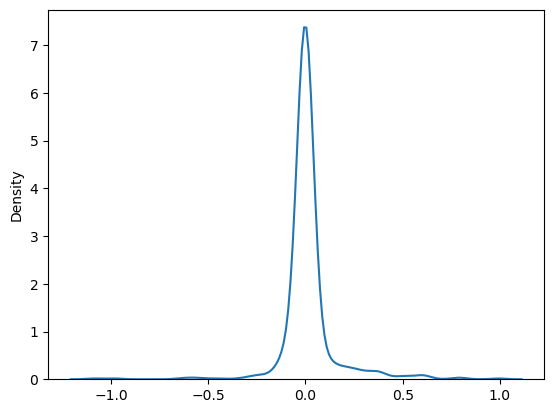

In [3]:
sns.kdeplot(lead.estimated_2019 - lead.most_recent)

/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: ylabel='Density'>

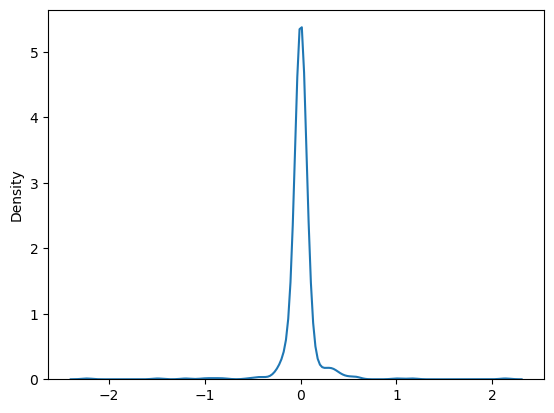

In [4]:
sns.kdeplot(trail.estimated_2019 - trail.most_recent)

In [5]:
len(lead)

586

In [6]:
len(trail)

593

# Prepare ECDF's for each species present in the dataset

In [7]:
f.head()

,genus,species,sci_name
0,Acantholabrus,palloni,Acantholabrus palloni
1,Aetobatus,narinari,Aetobatus narinari
2,Agonus,cataphractus,Agonus cataphractus
3,Albatrossia,pectoralis,Albatrossia pectoralis
4,Alectis,ciliaris,Alectis ciliaris


In [8]:
# this chunk of code creates an ECDF for each species
# in the dataset by calculating the proportion of the weighted Aquamaps range
# at each latitude and then taking the cumulative sum at each latitude
northsouth_ecdfs = {}

for i in range(len(f)):
    g = f.genus.loc[i].lower()
    s = f.species.loc[i].lower()
    filepath = f'fish_data/{g}_{s}.csv'
    full_map = pd.read_csv(filepath)
    northern_hemisphere = full_map.loc[full_map['Center Lat'] >= 0].reset_index(drop = True)

    net_density = northern_hemisphere.groupby('Center Lat')['Overall Probability'].sum().reset_index().sort_values(by = 'Center Lat')
    net_density['PMF'] = net_density['Overall Probability'] / net_density['Overall Probability'].sum()
    net_density['ECDF'] = net_density['PMF'].cumsum()

    northsouth_ecdfs[f.sci_name.loc[i]] = net_density[['Center Lat', 'ECDF']]
    northsouth_ecdfs[f.sci_name[i]].columns = ['latitude', 'ecdf']

In [9]:
# this chunk of code does the exact same as above, the only difference being
# we are only looking at aquamaps cells with a weight >= 0.8
prob_cutoff = 0.80
northsouth_ecdfs_high_density = {}

for i in range(len(f)):
    g = f.genus.loc[i].lower()
    s = f.species.loc[i].lower()
    filepath = f'fish_data/{g}_{s}.csv'
    full_map = pd.read_csv(filepath)
    full_map = full_map.loc[full_map['Overall Probability'] >= prob_cutoff]
    northern_hemisphere = full_map.loc[full_map['Center Lat'] >= 0].reset_index(drop = True)

    net_density = northern_hemisphere.groupby('Center Lat')['Overall Probability'].sum().reset_index().sort_values(by = 'Center Lat')
    net_density['PMF'] = net_density['Overall Probability'] / net_density['Overall Probability'].sum()
    net_density['ECDF'] = net_density['PMF'].cumsum()

    northsouth_ecdfs_high_density[f.sci_name.loc[i]] = net_density[['Center Lat', 'ECDF']]
    northsouth_ecdfs_high_density[f.sci_name[i]].columns = ['latitude', 'ecdf']

# Create dataframe of estimated range limits with same methodology as Fredston et al. 2020

"Because Aquamaps range edges are imprecise, we calculated the 5th and 95th percentile of latitudes where
each of these species occurs in Aquamaps with >80% probability." (Fredston et al., 2020)

In [79]:
'''
# create dataframe of all represented species with the fredston range limits
fredston_2020 = f.copy()

fred_leading = []
fred_trailing = []

# parameters
min_prob = 0.80
upper_quant = 0.95
lower_quant = 0.05

for i in range(len(fredston_2020)):
    g = fredston_2020.genus.loc[i].lower()
    s = fredston_2020.species.loc[i]
    filepath = f'fish_data/{g}_{s}.csv'
    full_map = pd.read_csv(filepath)
    northern_hemisphere = full_map.loc[full_map['Center Lat'] >= 0]
    
    # focus on only locations where species occurrence is >80%
    high_occurrence_map = northern_hemisphere.loc[northern_hemisphere['Overall Probability'] > min_prob].reset_index(drop = True).copy()

    # create PMF and ECDF
    net_density = high_occurrence_map.groupby('Center Lat')['Overall Probability'].sum().reset_index().sort_values(by = 'Center Lat')
    net_density['PMF'] = net_density['Overall Probability'] / net_density['Overall Probability'].sum()
    net_density['ECDF'] = net_density['PMF'].cumsum()

    # set range limits as the 95th and 5th percentiles
    leading_edge = net_density['Center Lat'].loc[net_density.ECDF <= upper_quant].max()
    trailing_edge = net_density['Center Lat'].loc[net_density.ECDF <= lower_quant].max()
    fred_leading.append(leading_edge)
    fred_trailing.append(trailing_edge)

fredston_2020['leading']  = fred_leading
fredston_2020['trailing'] = fred_trailing

fredston_2020.to_csv('fredston_range_edges.csv')
'''

"\n# create dataframe of all represented species with the fredston range limits\nfredston_2020 = f.copy()\n\nfred_leading = []\nfred_trailing = []\n\n# parameters\nmin_prob = 0.80\nupper_quant = 0.95\nlower_quant = 0.05\n\nfor i in range(len(fredston_2020)):\n    g = fredston_2020.genus.loc[i].lower()\n    s = fredston_2020.species.loc[i]\n    filepath = f'fish_data/{g}_{s}.csv'\n    full_map = pd.read_csv(filepath)\n    northern_hemisphere = full_map.loc[full_map['Center Lat'] >= 0]\n    \n    # focus on only locations where species occurrence is >80%\n    high_occurrence_map = northern_hemisphere.loc[northern_hemisphere['Overall Probability'] > min_prob].reset_index(drop = True).copy()\n\n    # create PMF and ECDF\n    net_density = high_occurrence_map.groupby('Center Lat')['Overall Probability'].sum().reset_index().sort_values(by = 'Center Lat')\n    net_density['PMF'] = net_density['Overall Probability'] / net_density['Overall Probability'].sum()\n    net_density['ECDF'] = net_dens

# Find percentile of north-south species distribution associated with each species

In [10]:
# list of all represented genus/species combinations
lead_names = lead.accepted_name.tolist()
trail_names = trail.accepted_name.tolist()
unique_names = list(set(lead_names + trail_names))
unique_genus = [names.split()[0].lower() for names in unique_names]
unique_species = [names.split()[1].lower() for names in unique_names]

In [11]:
# percentiles for the leading edges
percentile = [0] * len(lead)
high_density_percentile = [0] * len(lead)

for i,name in enumerate(lead.accepted_name):

    leading_edge = lead.estimated_2019[i]

    # first get the raw percentiles
    mapped_distribution = northsouth_ecdfs[name]
    max_lat = mapped_distribution.latitude.loc[mapped_distribution.latitude <= leading_edge].max()
    percentile[i] = mapped_distribution.ecdf.loc[mapped_distribution.latitude == max_lat].max()

    # now get the high density (prob >= 80%) percentiles
    high_density_mapped_distribution = northsouth_ecdfs_high_density[name]
    max_lat = high_density_mapped_distribution.latitude.loc[high_density_mapped_distribution.latitude <= leading_edge].max()
    high_density_percentile[i] = high_density_mapped_distribution.ecdf.loc[high_density_mapped_distribution.latitude == max_lat].max()

lead['percentile'] = percentile
lead['high_density_percentile'] = high_density_percentile

In [12]:
# percentiles for the trailing edges
percentile = [0] * len(trail)
high_density_percentile = [0] * len(trail)

for i,name in enumerate(trail.accepted_name):

    trailing_edge = trail.estimated_2019[i]

    # first get the raw percentiles
    mapped_distribution = northsouth_ecdfs[name]
    max_lat = mapped_distribution.latitude.loc[mapped_distribution.latitude <= trailing_edge].max()
    percentile[i] = mapped_distribution.ecdf.loc[mapped_distribution.latitude == max_lat].max()

    # now get the high density (prob >= 80%) percentiles
    high_density_mapped_distribution = northsouth_ecdfs_high_density[name]
    max_lat = high_density_mapped_distribution.latitude.loc[high_density_mapped_distribution.latitude <= trailing_edge].max()
    high_density_percentile[i] = high_density_mapped_distribution.ecdf.loc[high_density_mapped_distribution.latitude == max_lat].max()

trail['percentile'] = percentile
trail['high_density_percentile'] = high_density_percentile

## Visualize raw and high-density percentiles

### Leading Edge

In [102]:
data1 = np.array(lead.percentile.dropna())
data2 = np.array(lead.high_density_percentile.dropna())

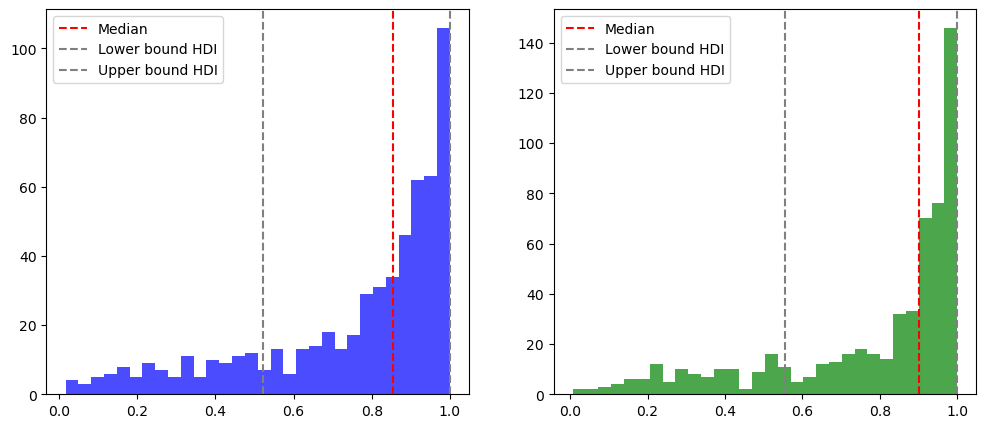

In [103]:
# Calculate the HDI using ArviZ
hdi1 = az.hdi(data1, hdi_prob=0.8)
hdi2 = az.hdi(data2, hdi_prob=0.8)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms
axs[0].hist(data1, bins=30, color='blue', alpha=0.7)
axs[1].hist(data2, bins=30, color='green', alpha=0.7)

# Add vertical lines for medians
axs[0].axvline(np.median(data1), color='red', linestyle='--', label='Median')
axs[1].axvline(np.median(data2), color='red', linestyle='--', label='Median')

# Add vertical lines for HDIs
axs[0].axvline(hdi1[0], color='gray', linestyle='--', label='Lower bound HDI')
axs[0].axvline(hdi1[1], color='gray', linestyle='--', label='Upper bound HDI')
axs[1].axvline(hdi2[0], color='gray', linestyle='--', label='Lower bound HDI')
axs[1].axvline(hdi2[1], color='gray', linestyle='--', label='Upper bound HDI')

# Show legend
axs[0].legend()
axs[1].legend()

plt.show()

In [106]:
np.median(data1), np.median(data2)

(0.8544220793284261, 0.9008159102498724)

In [108]:
# calculate 80% HDI for each
hdi_raw = az.hdi(data1, 0.80)
hdi_filtered = az.hdi(data2, 0.80)
hdi_raw, hdi_filtered

(array([0.52278018, 1.        ]), array([0.5554449, 1.       ]))

### Trailing Edge

In [110]:
data1 = np.array(trail.percentile.dropna())
data2 = np.array(trail.high_density_percentile.dropna())

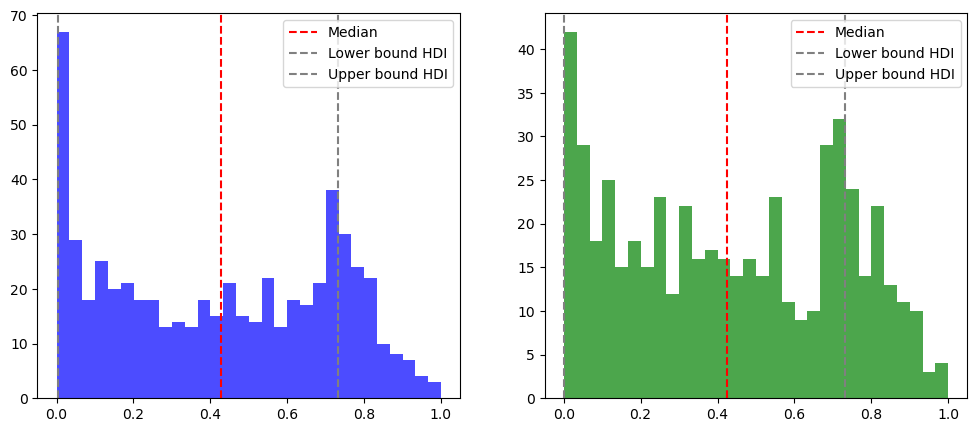

In [111]:
# Calculate the HDI using ArviZ
hdi1 = az.hdi(data1, hdi_prob=0.8)
hdi2 = az.hdi(data2, hdi_prob=0.8)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot histograms
axs[0].hist(data1, bins=30, color='blue', alpha=0.7)
axs[1].hist(data2, bins=30, color='green', alpha=0.7)

# Add vertical lines for medians
axs[0].axvline(np.median(data1), color='red', linestyle='--', label='Median')
axs[1].axvline(np.median(data2), color='red', linestyle='--', label='Median')

# Add vertical lines for HDIs
axs[0].axvline(hdi1[0], color='gray', linestyle='--', label='Lower bound HDI')
axs[0].axvline(hdi1[1], color='gray', linestyle='--', label='Upper bound HDI')
axs[1].axvline(hdi2[0], color='gray', linestyle='--', label='Lower bound HDI')
axs[1].axvline(hdi2[1], color='gray', linestyle='--', label='Upper bound HDI')

# Show legend
axs[0].legend()
axs[1].legend()

plt.show()

In [112]:
np.median(data1), np.median(data2)

(0.428514193803744, 0.4242785595039351)

In [113]:
# calculate 80% HDI for each
hdi_raw = az.hdi(data1, 0.80)
hdi_filtered = az.hdi(data2, 0.80)
hdi_raw, hdi_filtered

(array([0.00263395, 0.73167187]), array([4.76190476e-04, 7.31377307e-01]))

# Investigation of long-tailed leading edge distribution

In [52]:
lead.columns

Index(['accepted_name', 'ocean_continent', 'survey', 'season', 'edge',
       'response', 'method', 'start_year', 'end_year', 'slope', 'intercept',
       'estimated_2019', 'most_recent', 'percentile',
       'high_density_percentile'],
      dtype='object')

(array([ 12.,  19.,  21.,  26.,  32.,  26.,  45.,  59., 111., 231.]),
 array([0.01629519, 0.11466567, 0.21303615, 0.31140663, 0.40977711,
        0.50814759, 0.60651807, 0.70488856, 0.80325904, 0.90162952,
        1.        ]),
 <BarContainer object of 10 artists>)

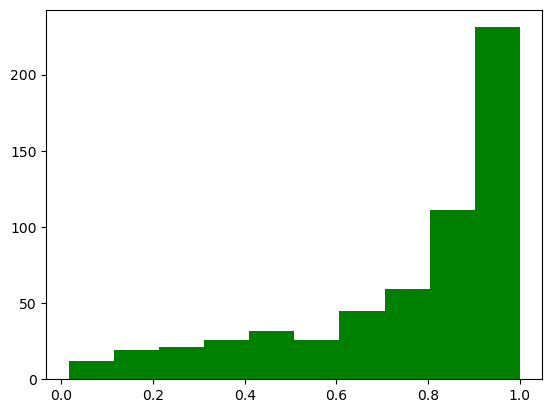

In [59]:
plt.hist(lead.percentile, color = 'green')

(array([  7.,  16.,  27.,  25.,  21.,  32.,  32.,  50.,  79., 292.]),
 array([0.00699211, 0.1062929 , 0.20559369, 0.30489448, 0.40419527,
        0.50349606, 0.60279685, 0.70209763, 0.80139842, 0.90069921,
        1.        ]),
 <BarContainer object of 10 artists>)

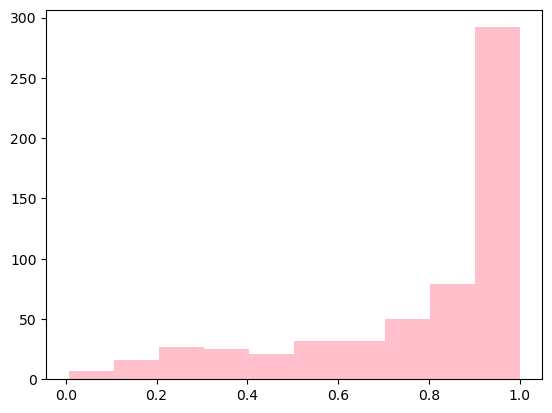

In [57]:
plt.hist(lead.high_density_percentile, color = 'pink')

In [60]:
lead.high_density_percentile.mean(), lead.percentile.mean()

(0.7799221062838526, 0.7547087088358603)

In [62]:
lead.high_density_percentile.var(), lead.percentile.var()

(0.06415869468943404, 0.06411306370536884)

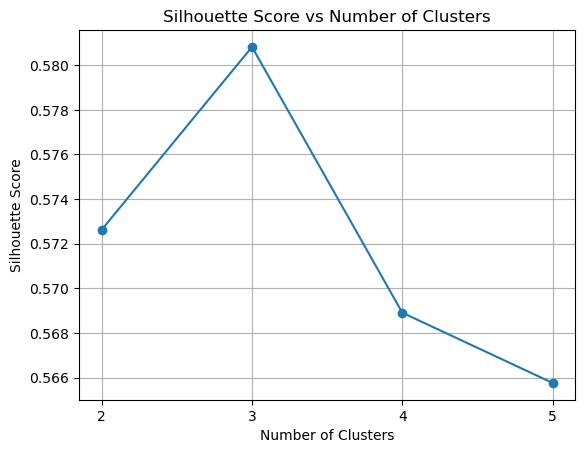

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

silhouette_scores = []
filtered_lead = lead.loc[~lead.percentile.isna()]

# Define the range of cluster counts to try
min_clusters = 2
max_clusters = 5

for cluster_count in range(min_clusters, max_clusters+1):
    data = np.log(1 - filtered_lead.percentile + 0.01).values.reshape(-1, 1)
    # Fit GMM with current number of clusters
    gmm = GaussianMixture(n_components=cluster_count, random_state=42)
    gmm.fit(data)
    
    # Predict cluster labels
    labels = gmm.predict(data)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(data, labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(range(min_clusters, max_clusters+1))
plt.grid(True)
plt.show()

# Investigating why some raw percentiles are worse-performing than the high-density percentiles

In [90]:
(lead.percentile >= lead.high_density_percentile).mean()

0.30204778156996587

In [91]:
(trail.percentile <= trail.high_density_percentile).mean()

0.30522765598650925

In [107]:
lead_anomalies = lead.accepted_name.loc[lead.percentile >= lead.high_density_percentile].sort_values()
trail_anomalies = trail.accepted_name.loc[trail.percentile <= trail.high_density_percentile].sort_values()

In [108]:
intersection = list(set(lead_anomalies) & set(trail_anomalies))

In [111]:
len(intersection), len(lead_anomalies), len(trail_anomalies)

(10, 177, 181)

## Trailing edge "anomalies"

In [203]:
trail['diff'] = trail.high_density_percentile - trail.percentile
trail.loc[trail.percentile < trail.high_density_percentile].sort_values(by = 'diff', ascending = False).head()

,accepted_name,ocean_continent,survey,season,edge,response,method,start_year,end_year,slope,intercept,estimated_2019,most_recent,percentile,high_density_percentile,diff
72,Boops boops,Atlantic Ocean-Europe,EVHOE,NaN,Trailing Edge,Latitude,Presence-Absence,1998,2020,-0.000545,45.154623,44.053385,44.052840,0.642515,0.881630,0.239115
265,Liparis gibbus,Pacific Ocean-North America,EBS,NaN,Trailing Edge,Latitude,Presence-Absence,1986,2019,-0.013053,83.515953,57.161145,57.161145,0.203307,0.363308,0.160002
367,Osmerus mordax,Pacific Ocean-North America,EBS,NaN,Trailing Edge,Latitude,Presence-Absence,1983,2017,0.012554,31.614699,56.961997,56.936888,0.658818,0.803706,0.144888
251,Leptoclinus maculatus,Pacific Ocean-North America,EBS,NaN,Trailing Edge,Latitude,Presence-Absence,1983,2019,-0.002635,61.008055,55.687691,55.687691,0.269021,0.393623,0.124602
92,Caranx hippos,Atlantic Ocean-North America,GMEX,FALL,Trailing Edge,Latitude,Presence-Absence,1989,2019,0.024607,-21.417340,28.263782,28.263782,0.607792,0.728514,0.120722


In [190]:
name = 'Anarhichas minor'
df = pd.read_csv('fish_data/anarhichas_minor.csv')

/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Text(0.5, 1.0, 'Raw')

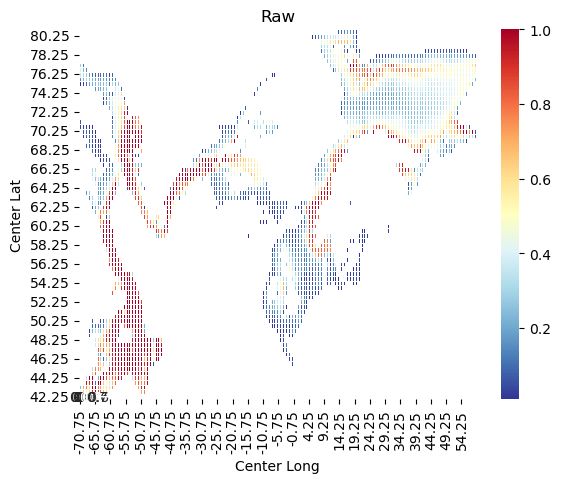

In [213]:
heatmap = sns.heatmap(df.pivot_table(index='Center Lat', columns='Center Long', values='Overall Probability'), cmap='RdYlBu_r', annot=True, fmt=".1f", linewidths=.5)
# Invert the y-axis
plt.gca().invert_yaxis()
plt.title('Raw')

In [214]:
df_high = df.loc[df['Overall Probability'] >= 0.80]

/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Text(0.5, 1.0, 'High Density Only')

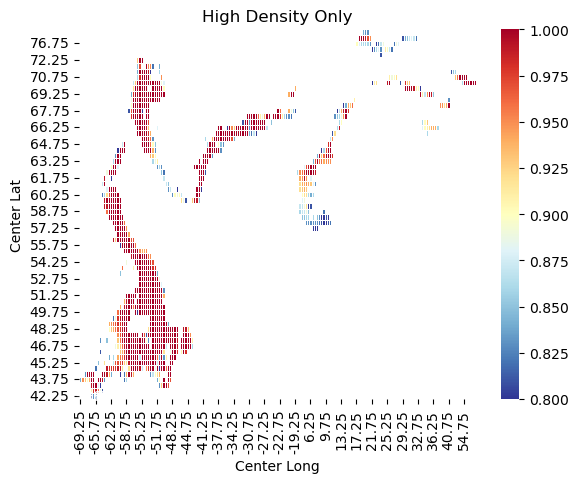

In [215]:
heatmap = sns.heatmap(df_high.pivot_table(index='Center Lat', columns='Center Long', values='Overall Probability'), cmap='RdYlBu_r', annot=True, fmt=".1f", linewidths=.5)
plt.gca().invert_yaxis()
plt.title('High Density Only')

In [216]:
ecdf = northsouth_ecdfs[name]
hi_ecdf = northsouth_ecdfs_high_density[name]
edge_anar_min = trail.estimated_2019.loc[trail.accepted_name == name].max()

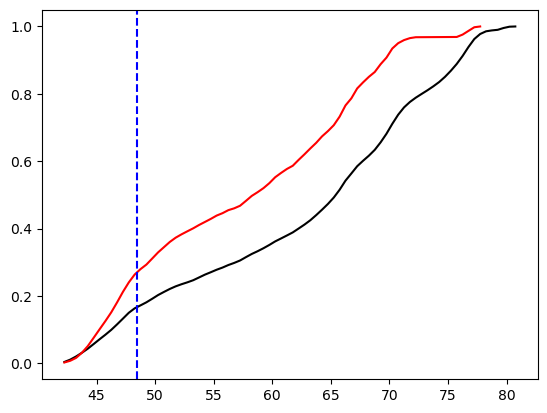

In [218]:
plt.plot(ecdf.latitude, ecdf.ecdf, color = 'black')
plt.plot(hi_ecdf.latitude, hi_ecdf.ecdf, color = 'red')
plt.axvline(x=edge_anar_min, color='blue', linestyle='--')
plt.show()

## Leading edge "anomalies"

In [237]:
lead['diff'] = lead.high_density_percentile - lead.percentile
lead.loc[lead.percentile > lead.high_density_percentile].sort_values(by = 'diff', ascending = True).loc[362]

accepted_name                 Ogcocephalus pantostictus
ocean_continent            Atlantic Ocean-North America
survey                                             GMEX
season                                           SUMMER
edge                                       Leading Edge
response                                       Latitude
method                                 Presence-Absence
start_year                                         1991
end_year                                           2019
slope                                          0.003168
intercept                                      22.66354
estimated_2019                                29.060657
most_recent                                   29.060657
percentile                                     0.803296
high_density_percentile                        0.510327
diff                                          -0.292969
Name: 362, dtype: object

In [223]:
name = 'Ogcocephalus pantostictus'
df = pd.read_csv('fish_data/ogcocephalus_pantostictus.csv')

/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Text(0.5, 1.0, 'Raw')

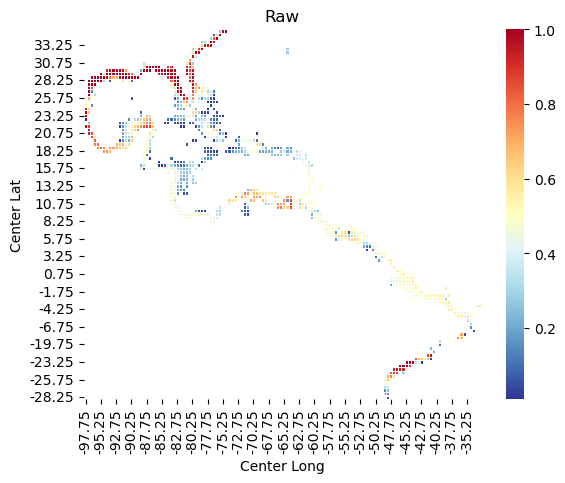

In [224]:
heatmap = sns.heatmap(df.pivot_table(index='Center Lat', columns='Center Long', values='Overall Probability'), cmap='RdYlBu_r', annot=True, fmt=".1f", linewidths=.5)
# Invert the y-axis
plt.gca().invert_yaxis()
plt.title('Raw')

In [225]:
df_high = df.loc[df['Overall Probability'] >= 0.80]

/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Text(0.5, 1.0, 'High Density Only')

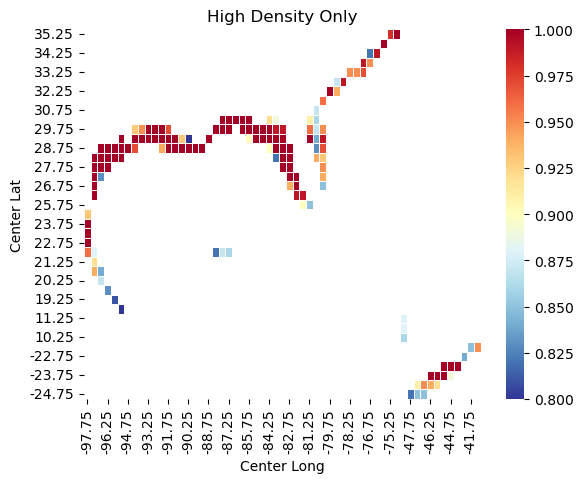

In [232]:
heatmap = sns.heatmap(df_high.pivot_table(index='Center Lat', columns='Center Long', values='Overall Probability'), cmap='RdYlBu_r', annot=True, fmt=".1f", linewidths=0.5)
plt.gca().invert_yaxis()
plt.title('High Density Only')

In [233]:
ecdf = northsouth_ecdfs[name]
hi_ecdf = northsouth_ecdfs_high_density[name]
edge_anar_max = trail.estimated_2019.loc[trail.accepted_name == name].max()

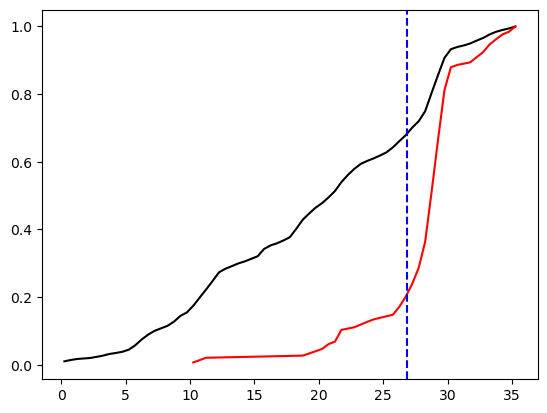

In [238]:
plt.plot(ecdf.latitude, ecdf.ecdf, color = 'black')
plt.plot(hi_ecdf.latitude, hi_ecdf.ecdf, color = 'red')
plt.axvline(x=edge_anar_max, color='blue', linestyle='--')
plt.show()

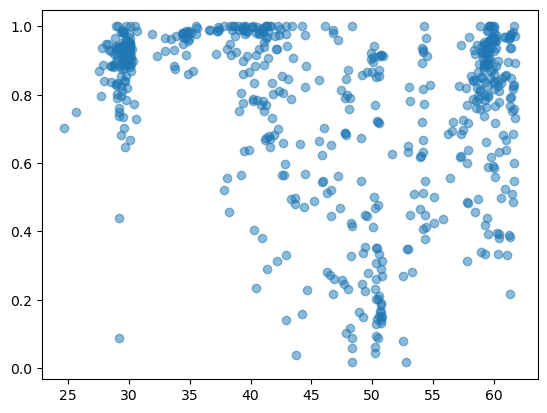

In [82]:
plt.scatter(lead.estimated_2019, lead.percentile, alpha = 0.5)

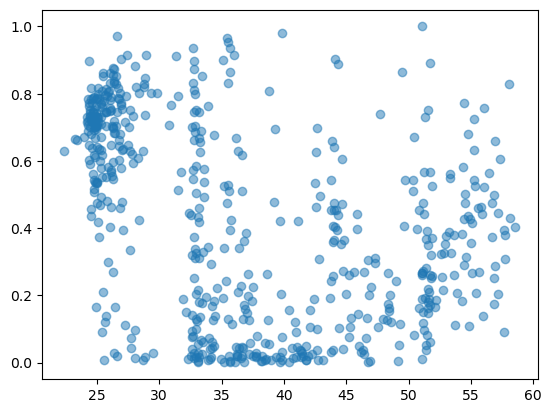

In [81]:
plt.scatter(trail.estimated_2019, trail.percentile, alpha = 0.5)

# Investigation of bi-modal trailing edge distribution

## Raw percentile

/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='percentile', ylabel='Density'>

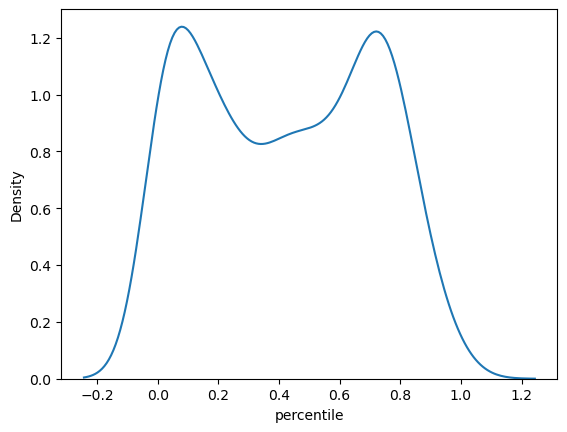

In [13]:
sns.kdeplot(trail.percentile)

In [31]:
from sklearn.mixture import GaussianMixture
np.random.seed(607)
filtered_trail = trail.loc[~trail.percentile.isna()]
cluster_count = 2

# Assuming trail.percentile is your data
data = filtered_trail.percentile.values.reshape(-1, 1)

# Instantiate and fit the GMM
gmm = GaussianMixture(n_components=cluster_count, random_state=42)
gmm.fit(data)

# Predict cluster labels
labels = gmm.predict(data)

# Add the cluster labels to the original DataFrame
trail_percentile_with_labels = pd.concat([filtered_trail.percentile, pd.Series(labels, index=filtered_trail.percentile.index, name='Cluster')], axis=1)

# Print cluster means and covariances
for i in range(cluster_count):
    cluster_data = data[labels == i]
    print(f"Cluster {i}:")
    print("Mean:", cluster_data.mean())
    print("Variance:")
    print(cluster_data.var())
    print()

Cluster 0:
Mean: 0.6602274556165322
Variance:
0.021641985031577823

Cluster 1:
Mean: 0.14492837532571842
Variance:
0.013518271799535497



In [36]:
good_estimates = filtered_trail.loc[labels == 1]
bad_estimates = filtered_trail.loc[labels == 0]
bad_estimates.percentile.mean(), good_estimates.percentile.mean()

(0.7025712490640462, 0.23570691801844612)

/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


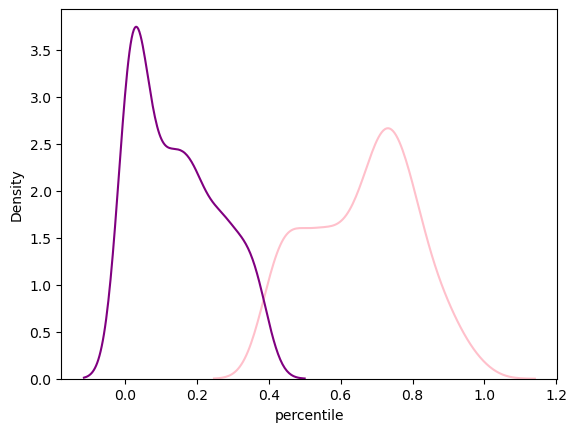

In [34]:
sns.kdeplot(bad_estimates.percentile, color = 'pink')
sns.kdeplot(good_estimates.percentile, color = 'purple')
plt.show()

(array([33., 31., 32., 29., 34., 65., 43., 24., 14.,  5.]),
 array([0.38800455, 0.44920409, 0.51040364, 0.57160318, 0.63280273,
        0.69400227, 0.75520182, 0.81640136, 0.87760091, 0.93880045,
        1.        ]),
 <BarContainer object of 10 artists>)

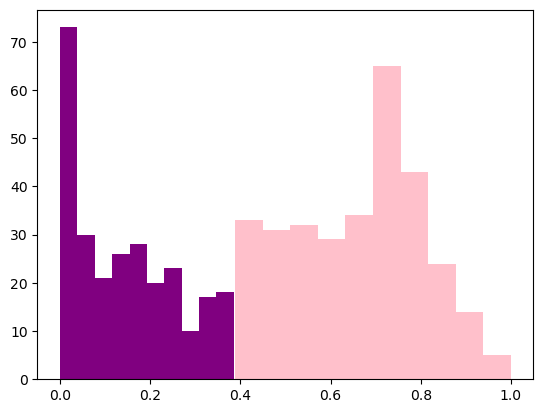

In [23]:
plt.hist(good_estimates.percentile, color = 'purple')
plt.hist(bad_estimates.percentile, color = 'pink')

In [24]:
bad_estimates.groupby('survey').accepted_name.count().sort_values(ascending = False).head()

survey
GMEX     170
WCANN     34
NEUS      19
EVHOE     18
SEUS      15
Name: accepted_name, dtype: int64

In [25]:
good_estimates.groupby('survey').accepted_name.count().sort_values(ascending = False).head()

survey
WCANN    80
NEUS     40
EVHOE    27
GMEX     18
AI       18
Name: accepted_name, dtype: int64

In [26]:
len(good_estimates), len(bad_estimates)

(266, 310)

## Repeat with the "high density percentile"

In [61]:
trail.high_density_percentile.mean(), trail.percentile.mean()

(0.4350649979110385, 0.42225947756556614)

In [63]:
trail.high_density_percentile.var(), trail.percentile.var()

(0.08180985483533748, 0.08403222005086446)

In [27]:
trail.columns

Index(['accepted_name', 'ocean_continent', 'survey', 'season', 'edge',
       'response', 'method', 'start_year', 'end_year', 'slope', 'intercept',
       'estimated_2019', 'most_recent', 'percentile',
       'high_density_percentile'],
      dtype='object')

/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='high_density_percentile', ylabel='Density'>

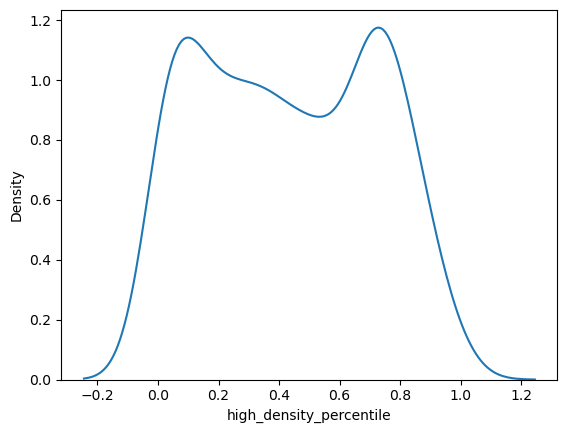

In [28]:
sns.kdeplot(trail.high_density_percentile)

In [47]:
filtered_trail = trail.loc[~trail.high_density_percentile.isna()]
cluster_count = 2
np.random.seed(608)
# Assuming trail.percentile is your data
data = filtered_trail.high_density_percentile.values.reshape(-1, 1)

# Instantiate and fit the GMM
gmm = GaussianMixture(n_components=cluster_count, random_state=42)
gmm.fit(data)

# Predict cluster labels
labels = gmm.predict(data)

# Add the cluster labels to the original DataFrame
trail_percentile_with_labels = pd.concat([filtered_trail.high_density_percentile, pd.Series(labels, index=filtered_trail.high_density_percentile.index, name='Cluster')], axis=1)

# Print cluster means and covariances
for i in range(cluster_count):
    cluster_data = data[labels == i]
    print(f"Cluster {i}:")
    print("Mean:", cluster_data.mean())
    print("Variance:")
    print(cluster_data.var())
    print()

Cluster 0:
Mean: 0.6969954641512182
Variance:
0.017843613800827905

Cluster 1:
Mean: 0.19320949441189433
Variance:
0.01873158826711784



In [49]:
bad_estimates = filtered_trail.loc[labels == 0]
good_estimates = filtered_trail.loc[labels == 1]
bad_estimates.high_density_percentile.mean(), good_estimates.high_density_percentile.mean()

(0.6969954641512182, 0.19320949441189433)

/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


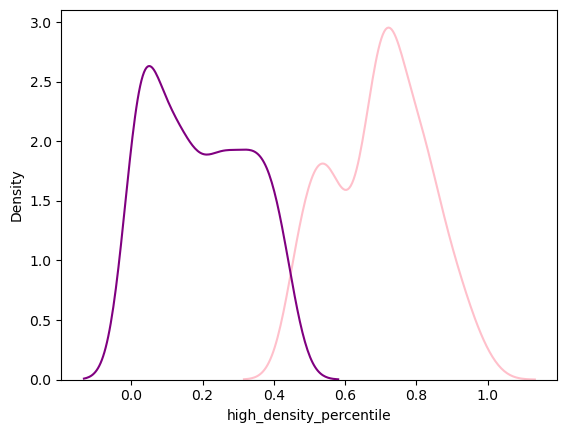

In [50]:
sns.kdeplot(bad_estimates.high_density_percentile, color = 'pink')
sns.kdeplot(good_estimates.high_density_percentile, color = 'purple')
plt.show()

(array([27., 30., 17., 19., 47., 40., 32., 24., 11.,  6.]),
 array([0.44867142, 0.50380428, 0.55893713, 0.61406999, 0.66920285,
        0.72433571, 0.77946857, 0.83460143, 0.88973428, 0.94486714,
        1.        ]),
 <BarContainer object of 10 artists>)

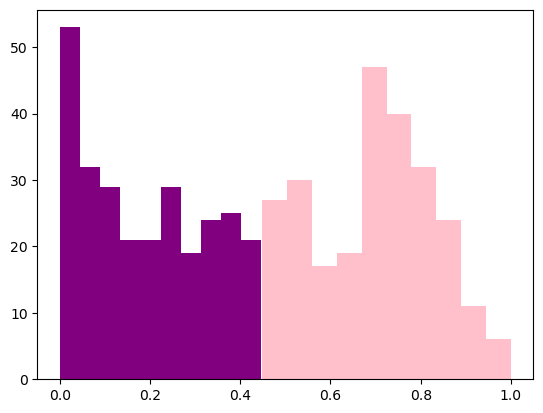

In [51]:
plt.hist(good_estimates.high_density_percentile, color = 'purple')
plt.hist(bad_estimates.high_density_percentile, color = 'pink')

## Plot silhouette scores to determine optimal clustering number

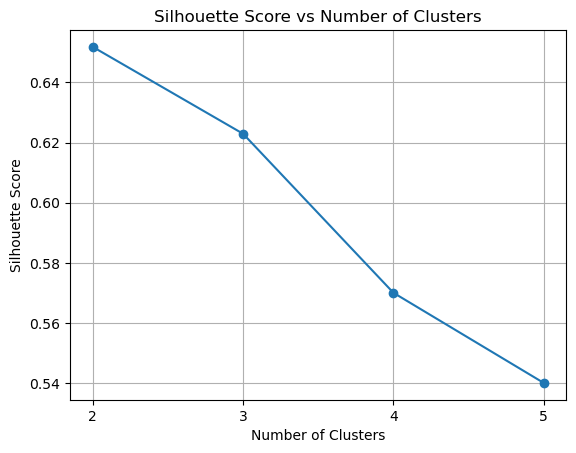

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Define the range of cluster counts to try
min_clusters = 2
max_clusters = 5

for cluster_count in range(min_clusters, max_clusters+1):
    data = filtered_trail.percentile.values.reshape(-1, 1)
    # Fit GMM with current number of clusters
    gmm = GaussianMixture(n_components=cluster_count, random_state=42)
    gmm.fit(data)
    
    # Predict cluster labels
    labels = gmm.predict(data)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(data, labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.plot(range(min_clusters, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(range(min_clusters, max_clusters+1))
plt.grid(True)
plt.show()

# Survey effectiveness boxplot

/var/folders/0j/mks53s7x7j16858sp0whvcdc0000gn/T/ipykernel_55539/395623344.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = trail.groupby('survey')['percentile'].mean().sort_values(ascending=False)
/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


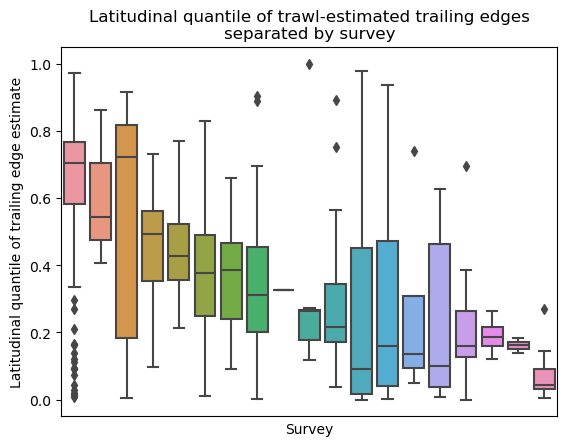

In [271]:
# Calculate mean values for each group
mean_values = trail.groupby('survey')['percentile'].mean().sort_values(ascending=False)

# Reorder the levels based on mean values
trail['survey'] = pd.Categorical(trail['survey'], categories=mean_values.index, ordered=True)

# Plotting the boxplot
sns.boxplot(y='percentile', x='survey', data=trail)

# Setting title and labels
plt.title('Latitudinal quantile of trawl-estimated trailing edges\nseparated by survey')
plt.ylabel('Latitudinal quantile of trailing edge estimate')
plt.xlabel('Survey')
plt.xticks([])

# savefig
plt.savefig('trailing_survey_quants_boxplot.png', dpi = 300)

# Show the plot
plt.show()

In [266]:
# Calculate mean values for each group
mean_values = trail.groupby('survey')['percentile'].mean()

# Sort the mean values in descending order
sorted_surveys = mean_values.sort_values(ascending=False).index.tolist()

# Print the list of surveys in order from highest mean to lowest mean
print("Trailing edge surveys in order from highest mean to lowest mean percentile (left to right):")
st = ''
for s in sorted_surveys:
    st = st + s + ', '
print(st[:-2])

Trailing edge surveys in order from highest mean to lowest mean percentile (left to right):
GMEX, FR-CGFS, SEUS, IE-IGFS, GOA, NS-IBTS, EBS, EVHOE, DFO-HS, DFO-QCS, AI, NEUS, WCANN, GSL-N, SCS, PT-IBTS, DFO-WCVI, BITS, GSL-S


/var/folders/0j/mks53s7x7j16858sp0whvcdc0000gn/T/ipykernel_55539/1363630336.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = trail.groupby('survey')['percentile'].mean()


/var/folders/0j/mks53s7x7j16858sp0whvcdc0000gn/T/ipykernel_55539/1249279639.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = lead.groupby('survey')['percentile'].mean().sort_values(ascending=False)
/Users/jameswagner/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


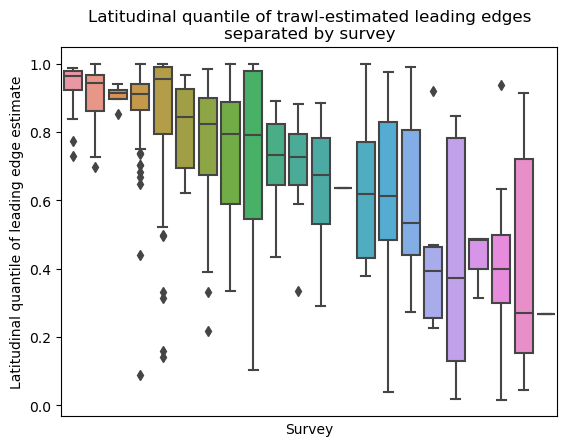

In [270]:
# Calculate mean values for each group
mean_values = lead.groupby('survey')['percentile'].mean().sort_values(ascending=False)

# Reorder the levels based on mean values
lead['survey'] = pd.Categorical(lead['survey'], categories=mean_values.index, ordered=True)

# Plotting the boxplot
sns.boxplot(y='percentile', x='survey', data=lead)

# Setting title and labels
plt.title('Latitudinal quantile of trawl-estimated leading edges\nseparated by survey')
plt.ylabel('Latitudinal quantile of leading edge estimate')
plt.xlabel('Survey')
plt.xticks([])

# savefig
plt.savefig('leading_survey_quants_boxplot.png', dpi = 300)

# Show the plot
plt.show()

In [267]:
# Calculate mean values for each group
mean_values = trail.groupby('survey')['percentile'].mean()

# Sort the mean values in descending order
sorted_surveys = mean_values.sort_values(ascending=False).index.tolist()

# Print the list of surveys in order from highest mean to lowest mean
print("Leading edge surveys in order from highest mean to lowest mean percentile (left to right):")
st = ''
for s in sorted_surveys:
    st = st + s + ', '
print(st[:-2])

Leading edge surveys in order from highest mean to lowest mean percentile (left to right):
GMEX, FR-CGFS, SEUS, IE-IGFS, GOA, NS-IBTS, EBS, EVHOE, DFO-HS, DFO-QCS, AI, NEUS, WCANN, GSL-N, SCS, PT-IBTS, DFO-WCVI, BITS, GSL-S


/var/folders/0j/mks53s7x7j16858sp0whvcdc0000gn/T/ipykernel_55539/1445303460.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_values = trail.groupby('survey')['percentile'].mean()


# Modeling trawl performance with season and estimate

In [240]:
import statsmodels.formula.api as smf

In [241]:
trail.columns

Index(['accepted_name', 'ocean_continent', 'survey', 'season', 'edge',
       'response', 'method', 'start_year', 'end_year', 'slope', 'intercept',
       'estimated_2019', 'most_recent', 'percentile',
       'high_density_percentile', 'diff'],
      dtype='object')

In [242]:
trail.season.unique()

array(['FALL', nan, 'SPRING', 'SUMMER'], dtype=object)

In [243]:
f = 'percentile ~ season'
m = smf.ols(f, trail).fit()

In [244]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             percentile   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     48.58
Date:                Wed, 13 Mar 2024   Prob (F-statistic):           8.55e-19
Time:                        23:02:37   Log-Likelihood:                -11.264
No. Observations:                 278   AIC:                             28.53
Df Residuals:                     275   BIC:                             39.41
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.5935      0.043     13.859      0.000       0.509       0.678
season[T.SPRING]    -0.3426      0.054     -6.318      0.000      -0.449      -0.236
season[T.SUMMER]     0.0300      0.047      0.643      0.521      -0.062       0.122
==============================================================================
Omnibus:                       10.468   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               12.412
Skew:                          -0.343   Prob(JB):                      0.00202
Kurtosis:                       3.776   Cond. No.                         6.34
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

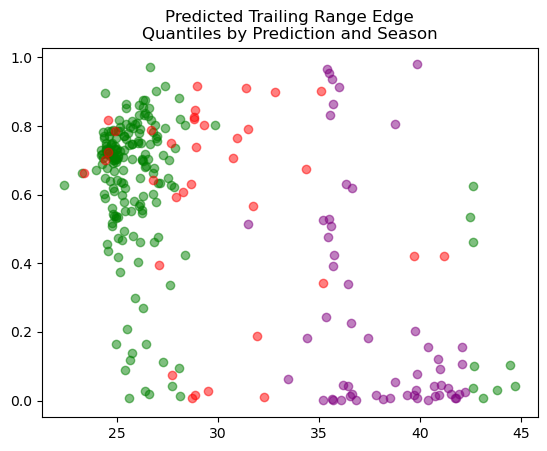

In [253]:
plt.scatter(trail.estimated_2019.loc[trail.season == 'SPRING'], trail.percentile.loc[trail.season == 'SPRING'], color = 'purple', alpha = 0.5)
plt.scatter(trail.estimated_2019.loc[trail.season == 'SUMMER'], trail.percentile.loc[trail.season == 'SUMMER'], color = 'green', alpha = 0.5)
plt.scatter(trail.estimated_2019.loc[trail.season == 'FALL'], trail.percentile.loc[trail.season == 'FALL'], color = 'red', alpha = 0.5)
plt.title('Predicted Trailing Range Edge\nQuantiles by Prediction and Season')
plt.show()

In [267]:
filtered_trail = trail[['percentile', 'season', 'estimated_2019']].dropna().reset_index(drop = True)

(array([31.,  6.,  3.,  1.,  3.,  4.,  2.,  0.,  3.,  5.]),
 array([3.39558574e-04, 9.82186384e-02, 1.96097718e-01, 2.93976798e-01,
        3.91855878e-01, 4.89734958e-01, 5.87614038e-01, 6.85493118e-01,
        7.83372197e-01, 8.81251277e-01, 9.79130357e-01]),
 <BarContainer object of 10 artists>)

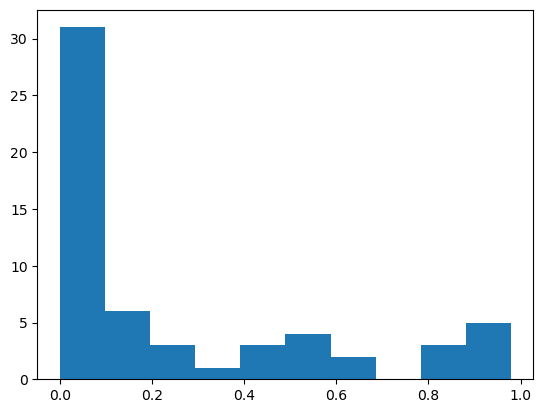

In [274]:
plt.hist(trail.percentile.loc[trail.season == 'SPRING'])

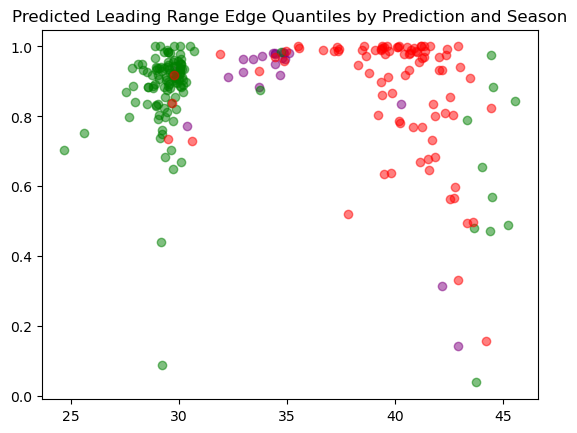

In [258]:
plt.scatter(lead.estimated_2019.loc[lead.season == 'SPRING'], lead.percentile.loc[lead.season == 'SPRING'], color = 'purple', alpha = 0.5)
plt.scatter(lead.estimated_2019.loc[lead.season == 'SUMMER'], lead.percentile.loc[lead.season == 'SUMMER'], color = 'green', alpha = 0.5)
plt.scatter(lead.estimated_2019.loc[lead.season == 'FALL'], lead.percentile.loc[lead.season == 'FALL'], color = 'red', alpha = 0.5)
plt.title('Predicted Leading Range Edge Quantiles by Prediction and Season')
plt.show()

In [255]:
f2 = 'percentile ~ season'
m2 = smf.ols(f2, lead).fit()

In [256]:
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             percentile   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.1300
Date:                Wed, 13 Mar 2024   Prob (F-statistic):              0.878
Time:                        23:09:03   Log-Likelihood:                 88.337
No. Observations:                 231   AIC:                            -170.7
Df Residuals:                     228   BIC:                            -160.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.8744      0.018     49.648      0.000       0.840       0.909
season[T.SPRING]    -0.0028      0.040     -0.069      0.945      -0.082       0.077
season[T.SUMMER]    -0.0116      0.023     -0.500      0.618      -0.057       0.034
==============================================================================
Omnibus:                      140.299   Durbin-Watson:                   1.854
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.235
Skew:                          -2.509   Prob(JB):                    5.01e-166
Kurtosis:                      10.342   Cond. No.                         4.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""